# Fayetteville Traffic Stops

Date: February 7, 2023

Recreate analysis from Frank R. Baumgartner's [Benchmarking Traffic Stop Data: Examining Patterns in North Carolina and the City of Raleigh](https://fbaum.unc.edu/TrafficStops/Baumgartner-benchmarking.pdf).

In [1]:
import logging


def configure_root_logger():
    console_logger = logging.StreamHandler()
    console_logger.setLevel(logging.DEBUG)
    console_logger.setFormatter(
        logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    )

    logger = logging.getLogger()
    logger.handlers = []  # reset handlers in case this cell is re-run
    logger.setLevel(logging.DEBUG)
    logger.addHandler(console_logger)
    return logger

In [2]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

In [3]:
import plotly
plotly.offline.init_notebook_mode()

In [4]:
logger = configure_root_logger()
pg_engine = create_engine("postgresql://postgres@db:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

# Data prep

In [5]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )
df = lookup_agencies({
    "Fayetteville Police",
})
agency_ids = df['id'].tolist()
df

id                            name
0  89  Fayetteville Police Department

In [6]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Investigatory
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.SEAT_BELT_VIOLATION.value, cls.INVESTIGATION.value, cls.CHECKPOINT.value]

In [7]:
stops_summary_sql = f"""
SELECT
    nc_stop.stop_id
    , date AT TIME ZONE 'America/New_York' AS stop_date
    , EXTRACT(hour FROM date AT TIME ZONE 'America/New_York') AS "hour_of_day"
    , nc_stop.agency_id
    , nc_stop.agency_description AS agency
    , nc_stop.officer_id
    , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
            ELSE 'Other'
       END) as stop_purpose_group
    , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
       END) as driver_race
    , (CASE WHEN nc_person.gender = 'M' THEN 'male'
            WHEN nc_person.gender = 'F' THEN 'female'
       END) as driver_gender
    , (nc_search.search_id IS NOT NULL) AS driver_searched
    , (CASE
        WHEN nc_contraband.contraband_id IS NULL THEN false
        ELSE true
        END) AS contraband_found
    , driver_arrest
FROM "nc_stop"
INNER JOIN "nc_person"
    ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
LEFT OUTER JOIN "nc_search"
    ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
LEFT OUTER JOIN "nc_contraband"
    ON ("nc_stop"."stop_id" = "nc_contraband"."stop_id")
WHERE nc_stop.agency_id IN ({",".join(map(str, agency_ids))})
"""

# Figures

## Figure 1: Percent of stops for safety-related purposes, by race, gender, and hour of day

In [8]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , stop_purpose_group
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY hour_of_day, driver_race, driver_gender)::integer AS total_hour_stops_by_race
    FROM stops
    GROUP BY 1, 2, 3, 4
    """,
    pg_engine,
)
df["percent_stops_for_race_gender"] = df.stop_count / df.total_hour_stops_by_race

In [9]:
black_drivers = df["driver_race"] == "Black"
male_drivers = df["driver_gender"] == "male"
midnight = df["hour_of_day"] == 0
df[black_drivers & male_drivers & midnight]

hour_of_day        stop_purpose_group driver_race driver_gender  \
9           0.0             Investigatory       Black          male   
10          0.0          Safety Violation       Black          male   
11          0.0  Regulatory and Equipment       Black          male   

    stop_count  total_hour_stops_by_race  percent_stops_for_race_gender  
9         1371                     19817                       0.069183  
10        8093                     19817                       0.408387  
11       10353                     19817                       0.522430

In [10]:
df[black_drivers & male_drivers & midnight].stop_count.sum()

19817

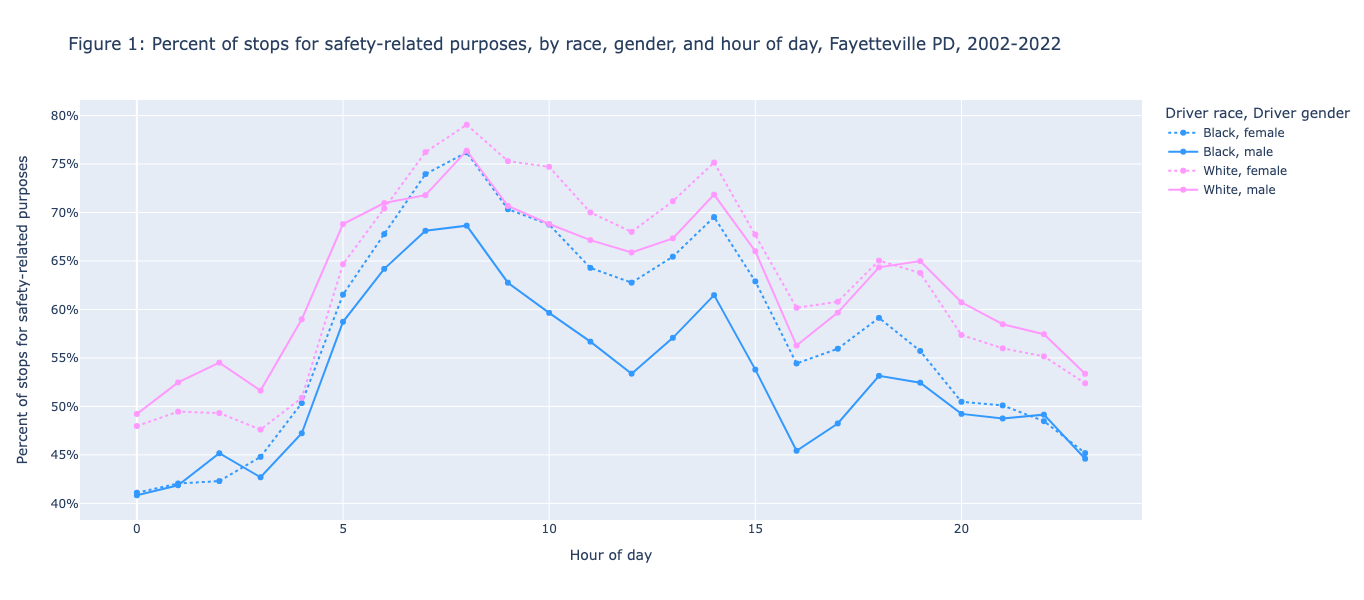

In [11]:
mask = (df["stop_purpose_group"] == "Safety Violation") & (df["driver_race"].isin(["Black", "White"]))
fig = px.line(
    df[mask],
    x="hour_of_day",
    y='percent_stops_for_race_gender',
    color="driver_race",
    title="Figure 1: Percent of stops for safety-related purposes, by race, gender, and hour of day, Fayetteville PD, 2002-2022",
    labels={
        'percent_stops_for_race_gender': 'Percent of stops for safety-related purposes',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

## Figure 2. Percent of traffic stops by race, gender, and hour of day

In [12]:
df2 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY hour_of_day)::integer AS total_hour_stops
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df2["percent_stops_for_race_gender"] = df2.stop_count / df2.total_hour_stops

In [13]:
midnight = df2["hour_of_day"] == 0
df2[midnight]

hour_of_day      driver_race driver_gender  stop_count  total_hour_stops  \
0           0.0            Asian        female         249             49149   
1           0.0            Asian          male         327             49149   
2           0.0            Black        female       10750             49149   
3           0.0            Black          male       19817             49149   
4           0.0         Hispanic        female         726             49149   
5           0.0         Hispanic          male        1779             49149   
6           0.0  Native American        female         163             49149   
7           0.0  Native American          male         255             49149   
8           0.0            Other        female          94             49149   
9           0.0            Other          male         229             49149   
10          0.0            White        female        5388             49149   
11          0.0            White          male        9372             49149   

    percent_stops_for_race_gender  
0                        0.005066  
1                        0.006653  
2                        0.218723  
3                        0.403203  
4                        0.014771  
5                        0.036196  
6                        0.003316  
7                        0.005188  
8                        0.001913  
9                        0.004659  
10                       0.109626  
11                       0.190685

In [14]:
df2[midnight].stop_count.sum()

49149

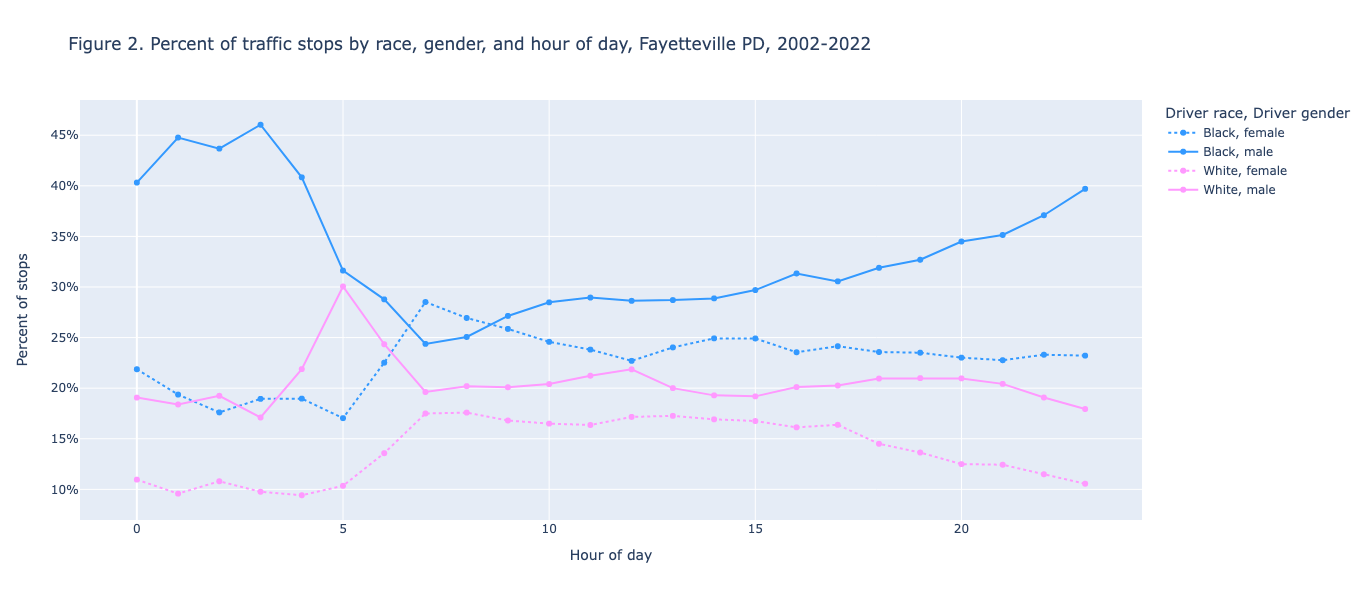

In [15]:
mask = df2["driver_race"].isin(["Black", "White"])
fig = px.line(
    df2[mask],
    x="hour_of_day",
    y='percent_stops_for_race_gender',
    color="driver_race",
    title="Figure 2. Percent of traffic stops by race, gender, and hour of day, Fayetteville PD, 2002-2022",
    labels={
        'percent_stops_for_race_gender': 'Percent of stops',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

## Figure 3. Percent of drivers searched by race, gender, and hour of day

In [16]:
df3 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df3["percent_stops_searched"] = df3.search_count / df3.stop_count

In [17]:
black_white_drivers = df3["driver_race"].isin(["Black", "White"])
midnight = df3["hour_of_day"] == 0
df3[black_white_drivers & midnight]

hour_of_day driver_race driver_gender  stop_count  search_count  \
2           0.0       Black        female       10750           360   
3           0.0       Black          male       19817          1954   
10          0.0       White        female        5388           186   
11          0.0       White          male        9372           559   

    percent_stops_searched  
2                 0.033488  
3                 0.098602  
10                0.034521  
11                0.059646

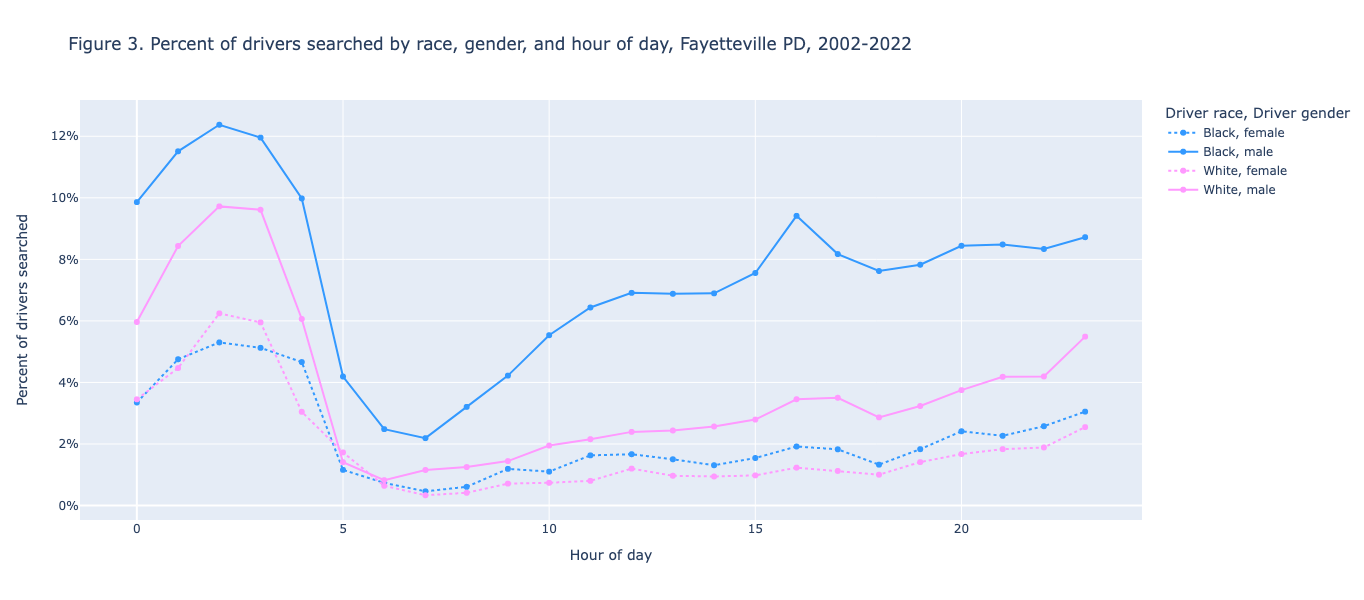

In [18]:
mask = df3["driver_race"].isin(["Black", "White"])
fig = px.line(
    df3[mask],
    x="hour_of_day",
    y='percent_stops_searched',
    color="driver_race",
    title="Figure 3. Percent of drivers searched by race, gender, and hour of day, Fayetteville PD, 2002-2022",
    labels={
        'percent_stops_searched': 'Percent of drivers searched',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

## Figure 4. Percent of drivers arrested by race, gender, and hour of day

In [19]:
df4 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS driver_arrest_count
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df4["percent_drivers_arrested"] = df4.driver_arrest_count / df4.stop_count

In [20]:
black_white_drivers = df4["driver_race"].isin(["Black", "White"])
midnight = df4["hour_of_day"] == 0
df4[black_white_drivers & midnight]

hour_of_day driver_race driver_gender  stop_count  search_count  \
2           0.0       Black        female       10750           360   
3           0.0       Black          male       19817          1954   
10          0.0       White        female        5388           186   
11          0.0       White          male        9372           559   

    driver_arrest_count  percent_drivers_arrested  
2                   172                  0.016000  
3                   688                  0.034718  
10                  102                  0.018931  
11                  290                  0.030943

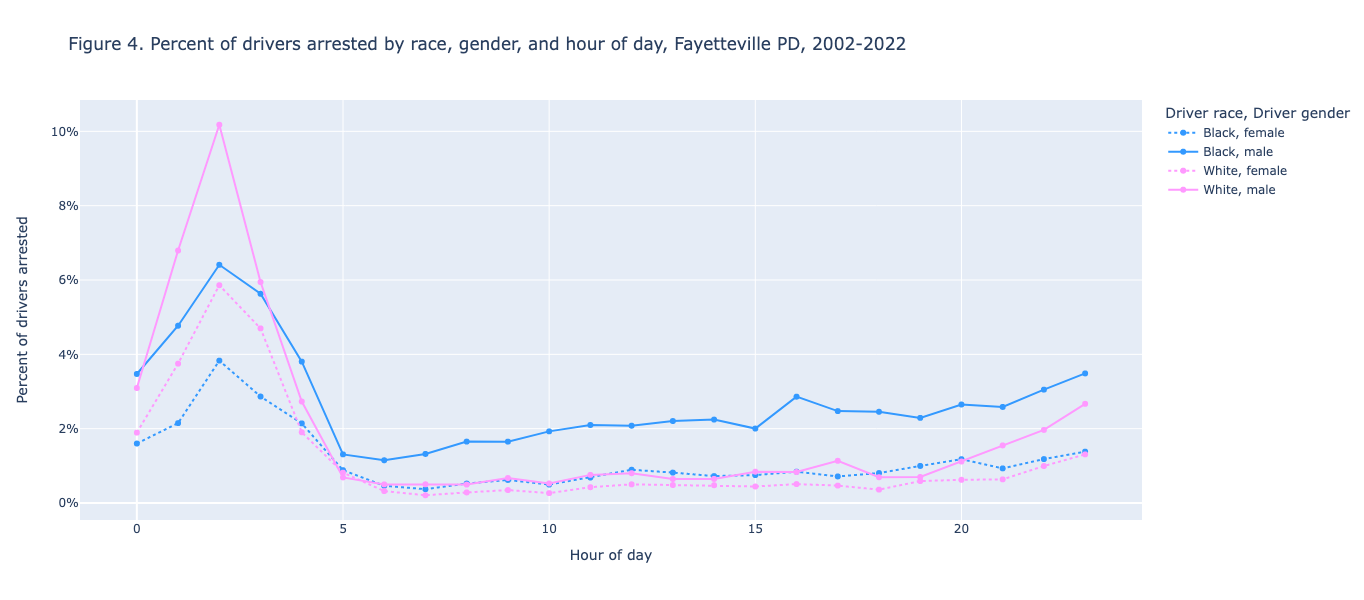

In [21]:
mask = df4["driver_race"].isin(["Black", "White"])
fig = px.line(
    df4[mask],
    x="hour_of_day",
    y='percent_drivers_arrested',
    color="driver_race",
    title="Figure 4. Percent of drivers arrested by race, gender, and hour of day, Fayetteville PD, 2002-2022",
    labels={
        'percent_drivers_arrested': 'Percent of drivers arrested',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

## Figure 5. Percent of black of drivers pulled over

In [22]:
df5 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        officer_id
        , driver_race
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY officer_id)::integer AS total_by_officer

    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df5["percent_drivers_stopped"] = df5.stop_count / df5.total_by_officer

In [23]:
minimum_100_stops = df5["total_by_officer"] >= 100
black_drivers = df5["driver_race"] == "Black"
black_and_white_drivers = df5["driver_race"].isin(["Black", "White"])

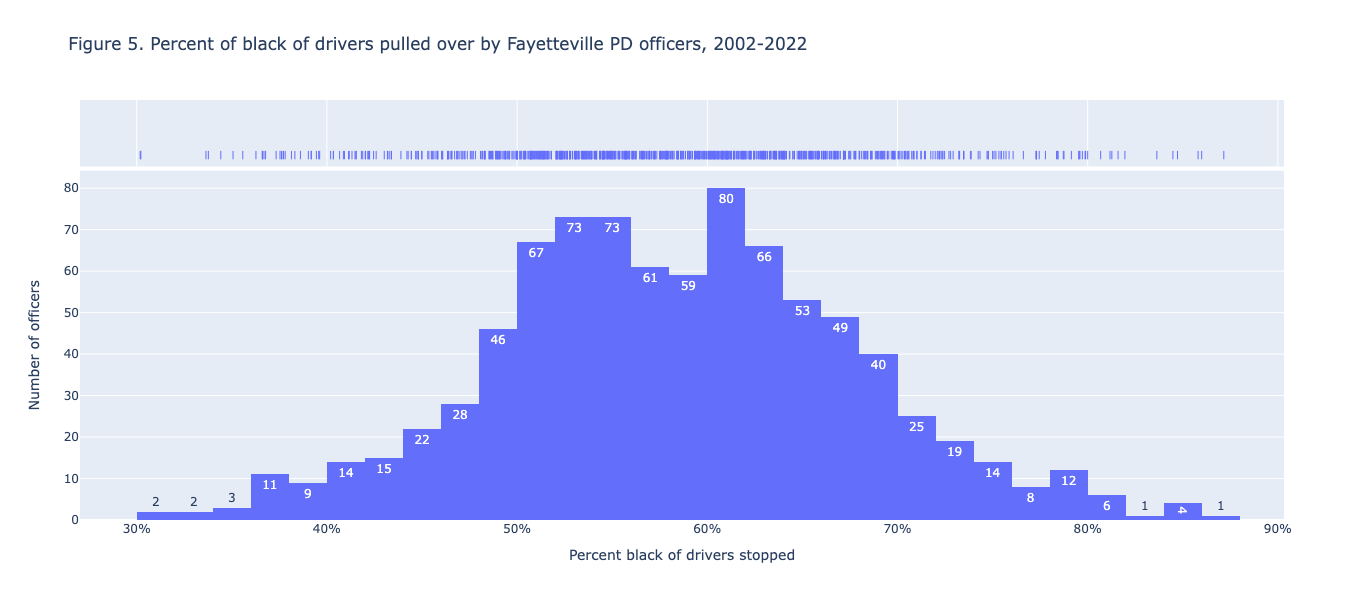

In [24]:
mask = black_drivers & minimum_100_stops
fig = px.histogram(
    df5[mask],
    title="Figure 5. Percent of black of drivers pulled over by Fayetteville PD officers, 2002-2022",
    x="percent_drivers_stopped",
    labels={
        'percent_drivers_stopped': 'Percent black of drivers stopped',
    },
    height=600,
    marginal="rug",
    text_auto=True,
)
fig.layout.xaxis.tickformat = ',.0%'
fig.update_layout(yaxis_title="Number of officers")
fig.show()

## Figure 5a. Percent of drivers pulled over

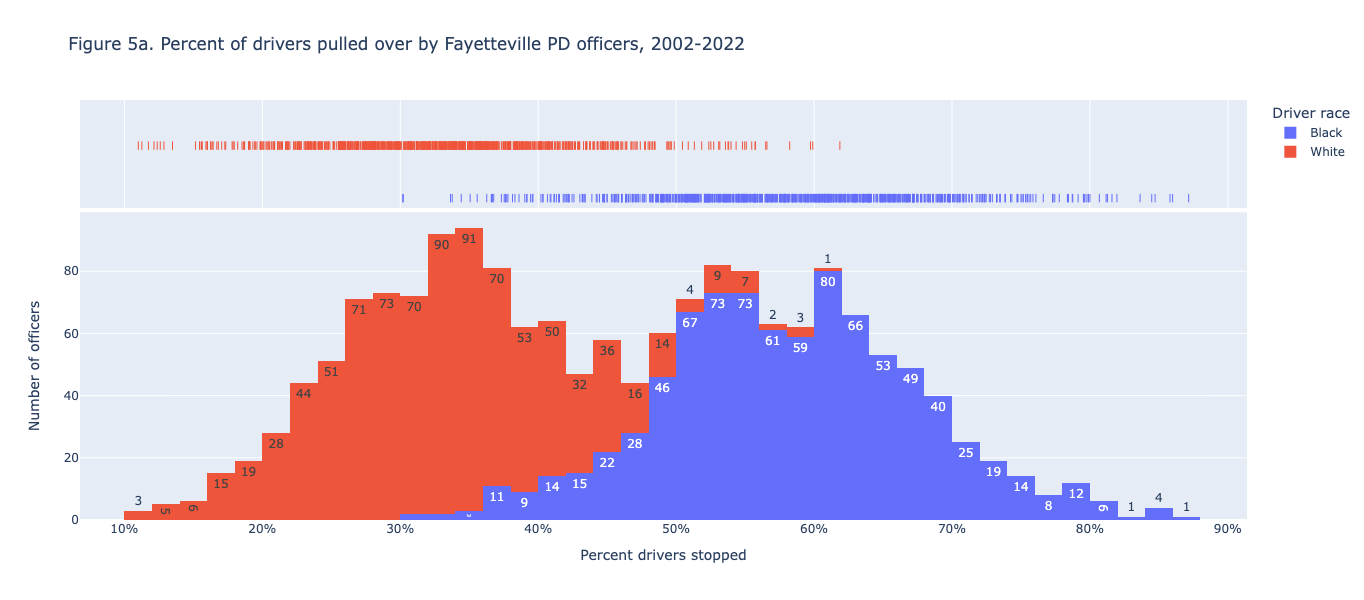

In [25]:
mask = black_and_white_drivers & minimum_100_stops
fig = px.histogram(
    df5[mask],
    title="Figure 5a. Percent of drivers pulled over by Fayetteville PD officers, 2002-2022",
    color="driver_race",
    x="percent_drivers_stopped",
    labels={
        'percent_drivers_stopped': 'Percent drivers stopped',
        'driver_race': 'Driver race',
    },
    height=600,
    marginal="rug",
    text_auto=True,
)
fig.layout.xaxis.tickformat = ',.0%'
fig.update_layout(yaxis_title="Number of officers")
fig.show()